In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from catboost import CatBoostRegressor
from sklearn.model_selection import TimeSeriesSplit

In [43]:
dataset=pd.read_csv('twins_1992-1997.csv')

In [45]:
dataset.head()
dataset.corr()

,year,month,day,latitude,longitude,zon.winds,mer.winds,humidity,air temp.,s.s.temp.
year,1.000000,-0.035773,-0.001598,0.025377,-0.065347,-0.136665,-0.008030,-0.052750,-0.096677,-0.108756
month,-0.035773,1.000000,0.008446,-0.006229,-0.012346,0.043942,0.236575,-0.139174,-0.140776,-0.102230
day,-0.001598,0.008446,1.000000,-0.004107,-0.003402,0.012608,0.000019,-0.005761,-0.009149,-0.006372
latitude,0.025377,-0.006229,-0.004107,1.000000,0.058606,0.130305,-0.012697,0.165024,0.067733,0.124631
longitude,-0.065347,-0.012346,-0.003402,0.058606,1.000000,0.423744,-0.063004,-0.031024,0.302220,0.384435
zon.winds,-0.136665,0.043942,0.012608,0.130305,0.423744,1.000000,0.089595,0.069842,0.217005,0.350441
mer.winds,-0.008030,0.236575,0.000019,-0.012697,-0.063004,0.089595,1.000000,0.126375,-0.384046,-0.325051
humidity,-0.052750,-0.139174,-0.005761,0.165024,-0.031024,0.069842,0.126375,1.000000,-0.411020,-0.358011
air temp.,-0.096677,-0.140776,-0.009149,0.067733,0.302220,0.217005,-0.384046,-0.411020,1.000000,0.944208
s.s.temp.,-0.108756,-0.102230,-0.006372,0.124631,0.384435,0.350441,-0.325051,-0.358011,0.944208,1.000000


In [47]:
dataset['humidity'].interpolate(inplace=True)

In [49]:
dataset['zon.winds'].fillna(np.random.normal(dataset['zon.winds'].mean(),dataset['zon.winds'].std()),inplace=True)
dataset['mer.winds'].fillna(np.random.normal(dataset['mer.winds'].mean(),dataset['mer.winds'].std()),inplace=True)

In [51]:
dataset['humidity']=dataset['humidity'].fillna(dataset['humidity'].mean(),)

In [53]:
dataset=dataset.dropna(subset=['air temp.'])

In [55]:
dataset.head()

,year,month,day,latitude,longitude,zon.winds,mer.winds,humidity,air temp.,s.s.temp.
0,1992,1,1,5.01,-110.00,-3.300000,3.600000,81.281851,26.39,27.40
1,1992,1,1,1.98,-140.40,-4.400000,4.100000,81.281851,27.75,28.27
2,1992,1,1,5.00,-140.00,-8.717008,-2.327972,81.281851,26.70,28.27
3,1992,1,1,-2.00,156.00,9.600000,4.300000,81.281851,27.77,29.39
4,1992,1,1,8.04,-110.06,-8.717008,-2.327972,86.300000,26.72,27.30


In [57]:
X = dataset[['latitude', 'longitude', 'zon.winds', 'mer.winds', 'humidity', 'air temp.']]
y = dataset['s.s.temp.']

In [59]:
tss=TimeSeriesSplit(n_splits=3)
for train,test in tss.split(X):
    X_train,X_test=X.iloc[train,:],X.iloc[test,:]
    y_train,y_test=y.iloc[train],y.iloc[test]
    

In [61]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [63]:
catboost_model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, random_seed=42, verbose=0)

In [65]:
catboost_model.fit(X_train, y_train)

In [66]:
y_pred = catboost_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")


model_score = catboost_model.score(X_test, y_test)
print(f"Model Score (R²): {model_score}")


results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(results_df)

Mean Squared Error: 0.21224038603845413
R-squared: 0.957629576990724
Model Score (R²): 0.957629576990724
       Actual  Predicted
58394   29.11  28.852088
58395   25.84  27.023594
58396   25.58  25.733935
58397   27.61  27.384875
58398   24.33  24.689427
...       ...        ...
77501   29.45  28.973024
77502   27.31  27.395396
77503   28.50  28.436813
77504   29.10  28.895124
77505   23.52  23.071072

[18039 rows x 2 columns]


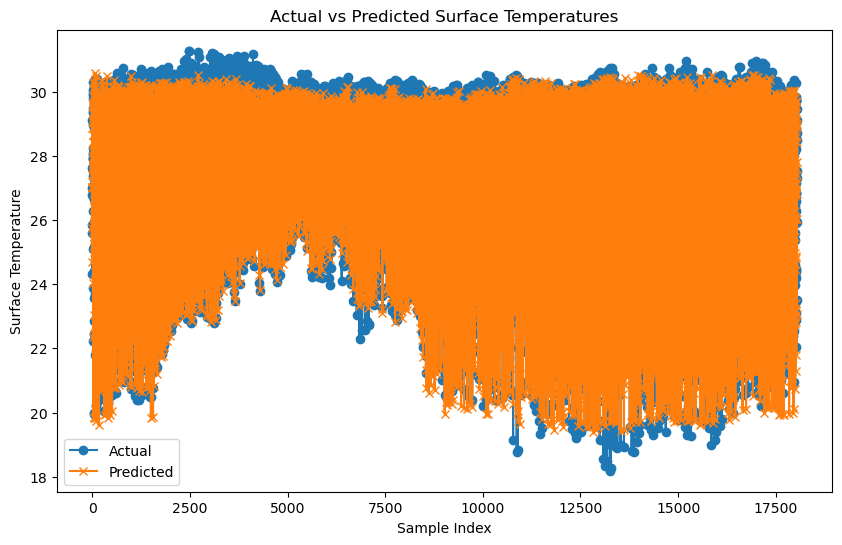

In [67]:

# Plotting the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(y_pred, label='Predicted', marker='x')
plt.title('Actual vs Predicted Surface Temperatures')
plt.xlabel('Sample Index')
plt.ylabel('Surface Temperature')
plt.legend()
plt.show()


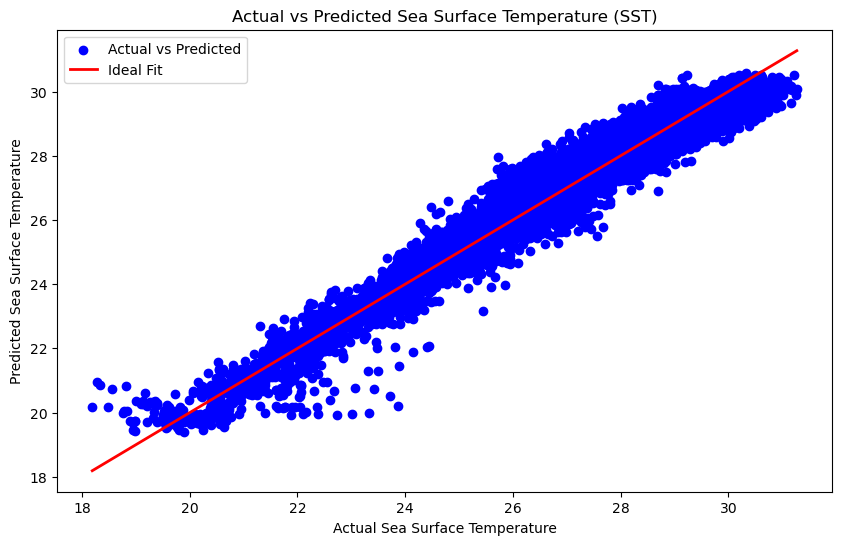

In [68]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', label='Actual vs Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2, label='Ideal Fit')
plt.xlabel('Actual Sea Surface Temperature')
plt.ylabel('Predicted Sea Surface Temperature')
plt.title('Actual vs Predicted Sea Surface Temperature (SST)')
plt.legend()
plt.show()